### Apply on Cryptocurrency

In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.dirname(os.getcwd())))

In [2]:
from Utils import get_data,generate_signals,result_analysis
import numpy as np
import pandas as pd
pd.options.display.max_colwidth = 60
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import seaborn as sns
import itertools
import datetime
from matplotlib.ticker import FormatStrFormatter

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


#### Data Downloading

In [3]:
Crypto_daily_category=['BTC','ETH','DASH','DOGE','LTC','MAID','XMR','XRP','NEO','EOS','ZEC']

In [4]:
Crypto_daily = get_data.cryptocurrency()
data_dict=Crypto_daily.daily_price_historical(Crypto_daily_category)

#### Data Cleaning

In [5]:
for i in data_dict.keys():
    print(i,len(data_dict[i]))
    print(data_dict[i].index[0],data_dict[i].index[-1])

BTC 3035
2010-07-16 2018-11-05
ETH 1188
2015-08-06 2018-11-05
DASH 1733
2014-02-07 2018-11-05
DOGE 1740
2014-01-31 2018-11-05
LTC 1840
2013-10-23 2018-11-05
MAID 1378
2015-01-28 2018-11-05
XMR 1378
2015-01-28 2018-11-05
XRP 1386
2015-01-20 2018-11-05
NEO 459
2017-08-04 2018-11-05
EOS 496
2017-06-28 2018-11-05
ZEC 740
2016-10-27 2018-11-05


In [6]:
start_date=data_dict['NEO'].index[0]

In [7]:
for i in data_dict.keys():
    data_dict[i]=data_dict[i][data_dict[i].index>=start_date]

In [8]:
for i in range(len(Crypto_daily_category)):
    index=Crypto_daily_category[i]
    data_dict[index]['date']=data_dict[index].index
    data_dict[index]['value']=data_dict[index].close
    data_dict[index].drop(['open','high','low','close'],axis=1,inplace=True)
    data_dict[index].reset_index(drop=True,inplace=True)

In [13]:
#if date is all the same
for j,k in itertools.combinations(range(len(Crypto_daily_category)),2):
    if(sum(data_dict[Crypto_daily_category[j]].date!=\
              data_dict[Crypto_daily_category[k]].date)>0):
        print('Dates of dataset '+Crypto_daily_category[j]+' and '+\
              Crypto_daily_category[k]+' are different')
date=data_dict[list(data_dict.keys())[0]].date

In [14]:
data_df=pd.DataFrame()
for i in range(len(Crypto_daily_category)):
    index=Crypto_daily_category[i]
    data_df[index]=data_dict[index].value
data_df.index=data_dict[index].date

In [15]:
A_re_df=((data_df-data_df.shift(1))/data_df.shift(1)).dropna()

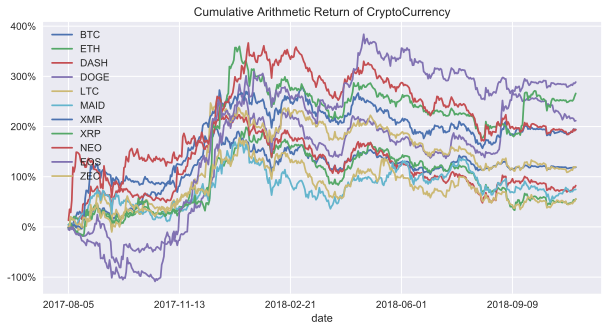

In [16]:
ax1=plt.subplot(111)
fmt='%.f%%'
ax1.yaxis.set_major_formatter(FormatStrFormatter(fmt))
A_re_cumsum=A_re_df.cumsum()*100
A_re_cumsum.plot(figsize=(10,5),ax=ax1)
plt.title('Cumulative Arithmetic Return of CryptoCurrency')
plt.show()

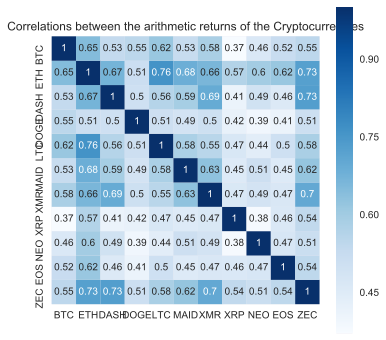

In [17]:
plt.subplots(figsize=(6,6))
sns.heatmap(A_re_df.corr(), annot=True, vmax=1, square=True, cmap="Blues")
plt.title('Correlations between the arithmetic returns of the Cryptocurrencies')
plt.show()

### Strategy: Weighth Changing day by day

### Mean Reverting

#### Sinal Generating

In [18]:
ret=(np.log(data_df)-np.log(data_df.shift(1))).dropna()

In [19]:
signal_class=generate_signals.signal_2(ret)

In [20]:
signal_class.get_signal('max')

In [21]:
position=signal_class.signal_df

In [22]:
trade_ret=(ret.loc[position.index]*position).sum(axis=1)

In [23]:
for i in range(len(trade_ret)):
    if trade_ret[i]>0:
        position.iloc[i,:]=-position.iloc[i,:]

#### Result Analysis

In [24]:
return_sep=ret.loc[position.index].iloc[1:,:].values*position.iloc[:-1,:]

In [25]:
daily_re=return_sep.sum(axis=1)

In [26]:
re_a1=result_analysis.result_daily(daily_re,365)
re_a1.get_metrics()
print('Annualized Return: ',re_a1.ar)
print('Annualized SD: ',re_a1.std)
print('Annualized Sharp Ratio: ',re_a1.sp)
print('Maximum draw down: ',re_a1.mdd)

Annualized Return:  -0.417306423677
Annualized SD:  0.741289838337
Annualized Sharp Ratio:  -0.282460734632
Maximum draw down:  -0.712777476164


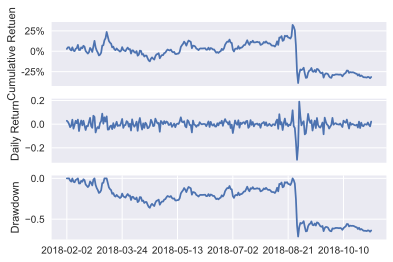

In [27]:
re_a1.figure_plot()

### Momentum

#### Signal Generating

In [28]:
signal_class.get_signal('min')

In [67]:
position=signal_class.signal_df
trade_ret=(ret.loc[position.index]*position).sum(axis=1)
for i in range(len(trade_ret)):
    if trade_ret[i]<0:
        position.iloc[i,:]=-position.iloc[i,:]

#### Result Analysis

In [68]:
return_sep=ret.loc[position.index].iloc[1:,:].values*position.iloc[:-1,:]
daily_re=return_sep.sum(axis=1)

In [69]:
re_a2=result_analysis.result_daily(daily_re,365)
re_a2.get_metrics()
print('Annualized Return: ',re_a2.ar)
print('Annualized SD: ',re_a2.std)
print('Annualized Sharp Ratio: ',re_a2.sp)
print('Maximum draw down: ',re_a2.mdd)

Annualized Return:  -0.0554104279916
Annualized SD:  0.741289838337
Annualized Sharp Ratio:  0.282460734632
Maximum draw down:  -0.410587607844


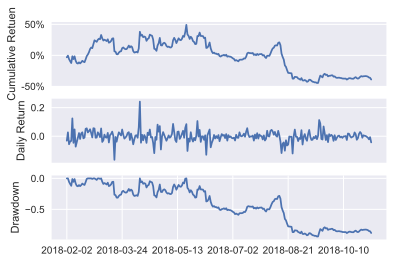

In [32]:
re_a2.figure_plot()

### Strategy: Finding the best Portfolio Size and Rolling Size

In [93]:
def sharp_ratio(step,opt):
    position_=signal_class.changing_rolling_size(step)
    trade_ret=(ret.loc[position_.index]*position_).sum(axis=1)
    if opt=='max':
        for i in range(len(trade_ret)):
            if trade_ret[i]>0:
                position_.iloc[i,:]=-position_.iloc[i,:]
    elif opt=='min':
        for i in range(len(trade_ret)):
            if trade_ret[i]<0:
                position_.iloc[i,:]=-position_.iloc[i,:]
    return_sep=ret.loc[position_.index].iloc[1:,:].values*position_.iloc[:-1,:]
    daily_re=return_sep.sum(axis=1)
    re=result_analysis.result_daily(daily_re,365)
    re.get_metrics()
    return re.sp

#### Momentum

In [104]:
sp_df=pd.DataFrame()
x=np.arange(1,100)
for k in range(3,6):
    signal_class=generate_signals.signal_2(ret,card=k)
    signal_class.get_signal('max')
    sp_df['card'+str(k)]=[sharp_ratio(i,'max') for i in x]

In [116]:
sp_df.iloc[sp_df.idxmax()]

,card3,card4,card5
31,1.362989,0.703999,1.688864
30,1.023826,1.143289,1.648982
45,-0.919056,0.271720,1.958395


In [118]:
best_k,best_step=5,46

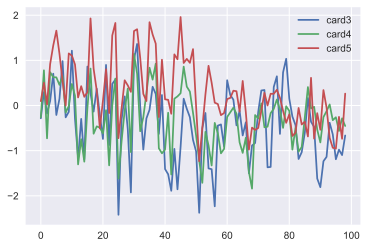

In [117]:
sp_df.plot()
plt.show()

In [119]:
signal_class=generate_signals.signal_2(ret,card=best_k)
signal_class.get_signal('max')
position_=signal_class.changing_rolling_size(best_step)
trade_ret=(ret.loc[position_.index]*position_).sum(axis=1)
for i in range(len(trade_ret)):
    if trade_ret[i]>0:
        position_.iloc[i,:]=-position_.iloc[i,:]
return_sep=ret.loc[position_.index].iloc[1:,:].values*position_.iloc[:-1,:]
daily_re=return_sep.sum(axis=1)
re=result_analysis.result_daily(daily_re,365)

In [120]:
re.get_metrics()
print('Annualized Return: ',re.ar)
print('Annualized SD: ',re.std)
print('Annualized Sharp Ratio: ',re.sp)
print('Maximum draw down: ',re.mdd)

Annualized Return:  1.31324504075
Annualized SD:  0.540884832605
Annualized Sharp Ratio:  1.95839499135
Maximum draw down:  -0.512482625913


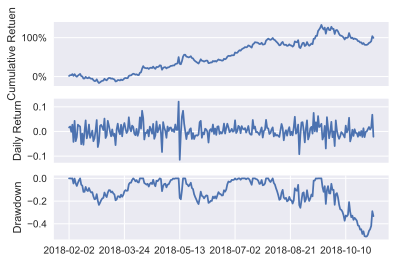

In [121]:
re.figure_plot()

#### Mean Reverting

In [122]:
sp_df=pd.DataFrame()
x=np.arange(1,100)
for k in range(3,6):
    signal_class=generate_signals.signal_2(ret,card=k)
    signal_class.get_signal('min')
    sp_df['card'+str(k)]=[sharp_ratio(i,'min') for i in x]

In [123]:
sp_df.iloc[sp_df.idxmax()]

,card3,card4,card5
92,1.394405,1.103299,0.420476
91,1.021401,1.818581,0.988886
80,0.930186,0.613805,1.779836


In [125]:
best_k,best_step=4,92

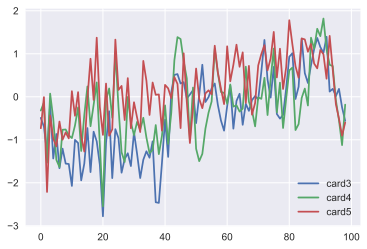

In [124]:
sp_df.plot()
plt.show()

In [95]:
best_step=np.argmax(sp_list)+1

In [126]:
signal_class=generate_signals.signal_2(ret,best_k)
signal_class.get_signal('min')
position_=signal_class.changing_rolling_size(best_step)
trade_ret=(ret.loc[position_.index]*position_).sum(axis=1)
for i in range(len(trade_ret)):
    if trade_ret[i]<0:
        position_.iloc[i,:]=-position_.iloc[i,:]
return_sep=ret.loc[position_.index].iloc[1:,:].values*position_.iloc[:-1,:]
daily_re=return_sep.sum(axis=1)
re=result_analysis.result_daily(daily_re,365)

In [127]:
re.get_metrics()
print('Annualized Return: ',re.ar)
print('Annualized SD: ',re.std)
print('Annualized Sharp Ratio: ',re.sp)
print('Maximum draw down: ',re.mdd)

Annualized Return:  1.33966418854
Annualized SD:  0.61076332178
Annualized Sharp Ratio:  1.81858070818
Maximum draw down:  -0.458321063027


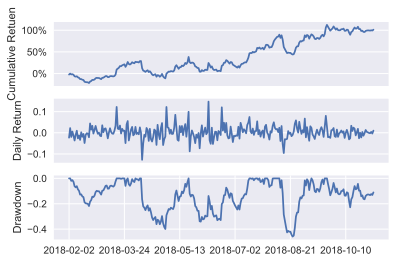

In [128]:
re.figure_plot()